Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\flare\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
C:\Users\flare\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


epoch: 0  validation loss: 0.17248419
epoch: 1  validation loss: 0.17304894
epoch: 2  validation loss: 0.17316653
epoch: 3  validation loss: 0.17285866
epoch: 4  validation loss: 0.17204347
epoch: 5  validation loss: 0.1720529
epoch: 6  validation loss: 0.17250098
epoch: 7  validation loss: 0.17458053
epoch: 8  validation loss: 0.17207702
epoch: 9  validation loss: 0.17202564
epoch: 10  validation loss: 0.17260167
epoch: 11  validation loss: 0.17246771
epoch: 12  validation loss: 0.17204009
epoch: 13  validation loss: 0.17415231
epoch: 14  validation loss: 0.17210627
epoch: 15  validation loss: 0.17318684
epoch: 16  validation loss: 0.17461717
epoch: 17  validation loss: 0.1723949
epoch: 18  validation loss: 0.17203417
epoch: 19  validation loss: 0.17395937
epoch: 20  validation loss: 0.17327218
epoch: 21  validation loss: 0.17231917
epoch: 22  validation loss: 0.17267078
epoch: 23  validation loss: 0.17202546
epoch: 24  validation loss: 0.17246737
epoch: 25  validation loss: 0.172372


epoch: 207  validation loss: 0.000613463
epoch: 208  validation loss: 0.0004982586
epoch: 209  validation loss: 0.0005868737
epoch: 210  validation loss: 0.000597162
epoch: 211  validation loss: 0.00046230512
epoch: 212  validation loss: 0.00042658224
epoch: 213  validation loss: 0.00055070623
epoch: 214  validation loss: 0.0007062372
epoch: 215  validation loss: 0.00097492454
epoch: 216  validation loss: 0.0004173805
epoch: 217  validation loss: 0.0003975665
epoch: 218  validation loss: 0.00040149456
epoch: 219  validation loss: 0.00031516995
epoch: 220  validation loss: 0.0005520089
epoch: 221  validation loss: 0.0005364204
epoch: 222  validation loss: 0.00028228748
epoch: 223  validation loss: 0.00032286733
epoch: 224  validation loss: 0.00027805593
epoch: 225  validation loss: 0.00032458288
epoch: 226  validation loss: 0.0003330592
epoch: 227  validation loss: 0.0006512767
epoch: 228  validation loss: 0.00022921638
epoch: 229  validation loss: 0.00022925073
epoch: 230  validation l

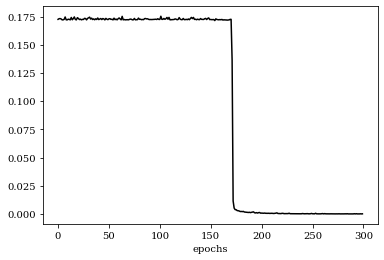

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

np.random.seed(0)
tf.random.set_seed(1234)

def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.compat.v1.truncated_normal(shape, stddev=0.01)
        return tf.compat.v1.Variable(initial)

    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.compat.v1.Variable(initial)

    cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    initial_state = cell.zero_state(n_batch, tf.float32)

    state = initial_state
    outputs = []  # 過去の隠れ層の出力を保存
    with tf.compat.v1.variable_scope('LSTM'):
        for t in range(maxlen):
            if t > 0:
                tf.compat.v1.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)

    output = outputs[-1]

    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c  # 線形活性

    return y


def loss(y, t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse


def training(loss):
    optimizer = \
        tf.compat.v1.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)

    train_step = optimizer.minimize(loss)
    return train_step


if __name__ == '__main__':
    def mask(T=200):
        mask = np.zeros(T)
        indices = np.random.permutation(np.arange(T))[:2]
        mask[indices] = 1
        return mask

    def toy_problem(N=10, T=200):
        signals = np.random.uniform(low=0.0, high=1.0, size=(N, T))
        masks = np.zeros((N, T))
        for i in range(N):
            masks[i] = mask(T)

        data = np.zeros((N, T, 2))
        data[:, :, 0] = signals[:]
        data[:, :, 1] = masks[:]
        target = (signals * masks).sum(axis=1).reshape(N, 1)

        return (data, target)

    '''
    データの生成
    '''
    N = 10000
    T = 200
    maxlen = T

    X, Y = toy_problem(N=N, T=T)

    N_train = int(N * 0.9)
    N_validation = N - N_train

    X_train, X_validation, Y_train, Y_validation = \
        train_test_split(X, Y, test_size=N_validation)

    '''
    モデル設定
    '''
    n_in = len(X[0][0])  # 2
    n_hidden = 100
    n_out = len(Y[0])  # 1

    x = tf.compat.v1.placeholder(tf.float32, shape=[None, maxlen, n_in])
    t = tf.compat.v1.placeholder(tf.float32, shape=[None, n_out])
    n_batch = tf.compat.v1.placeholder(tf.int32, shape=[])

    y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out)
    loss = loss(y, t)
    train_step = training(loss)

    history = {
        'val_loss': []
    }

    '''
    モデル学習
    '''
    epochs = 300
    batch_size = 100

    init = tf.compat.v1.global_variables_initializer()
    sess = tf.compat.v1.Session()
    sess.run(init)

    n_batches = N_train // batch_size

    for epoch in range(epochs):
        X_, Y_ = shuffle(X_train, Y_train)

        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size

            sess.run(train_step, feed_dict={
                x: X_[start:end],
                t: Y_[start:end],
                n_batch: batch_size
            })

        # 検証データを用いた評価
        val_loss = loss.eval(session=sess, feed_dict={
            x: X_validation,
            t: Y_validation,
            n_batch: N_validation
        })

        history['val_loss'].append(val_loss)
        print('epoch:', epoch,
              ' validation loss:', val_loss)

    '''
    学習の進み具合を可視化
    '''
    loss = history['val_loss']

    plt.rc('font', family='serif')
    fig = plt.figure()
    plt.plot(range(len(loss)), loss, label='loss', color='black')
    plt.xlabel('epochs')
    plt.show()